## RPC- Classification

In [338]:
import splitfolders
import os
import torch,torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import v2




#### Dataset loading and preprocessing

In [339]:
file_name = "dataset"

# Splitting folders
splitfolders.ratio(file_name,seed=1337, ratio=(0.8,0.2))

train_path = "./output/train"
test_path = "./output/val"

Copying files: 0 files [00:00, ? files/s]

Copying files: 2188 files [00:00, 4204.35 files/s]


In [340]:
transform = v2.Compose([
  v2.Resize((64,64)),
  v2.RandomRotation(degrees=(90,180)),
  v2.RandomHorizontalFlip(p=0.7),
  
  v2.ToTensor(),
  # v2.Lambda(lambda x: (x>0.5).float())
  v2.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

/home/bititude/anaconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [341]:
test_transform = v2.Compose(
    [
        v2.Resize((64, 64)),
        v2.ToTensor(),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [342]:
# preparing data for training

train_dataset = torchvision.datasets.ImageFolder(root=train_path,transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=transform)


train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [343]:
class_names = train_dataset.classes
class_names

['paper', 'rock', 'scissors']

In [344]:
img,label=train_dataset[1234]

In [345]:
img.size()

torch.Size([3, 64, 64])

#### Define model and training

In [346]:
import torch.nn as nn
from torch.nn import MaxPool2d, Conv2d, Dropout ,Linear
import torch.nn.functional as F
import torch.optim as optim

In [347]:
class Model(nn.Module):
    def __init__(self):
      super().__init__()

      self.cnv1 = Conv2d(3,8,3)  # (62,62)
      self.pool1 = MaxPool2d(2,2) #(31,31)
      self.cnv2 = Conv2d(8,16,5) #(27,27)
      self.pool2 = MaxPool2d(3,3) #(9,9) 

      # -> flatten  (32*9*9)

      self.fc1 = Linear(16*9*9,64)
      self.fc2 = Linear(64,128)
      self.fc3 = Linear(128,64)
      self.fc4 = Linear(64,32)
      self.fc5 = Linear(32,3)

      self.drop1 = Dropout(p=0.2)

      

    def forward(self,x):

      x = self.pool1(F.relu(self.cnv1(x)))
      x = self.pool2(F.relu(self.cnv2(x)))
      x = torch.flatten(x,1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.drop1(x)
      x = F.relu(self.fc3(x))
      x = self.drop1(x)
      x = F.relu(self.fc4(x))
      x = self.fc5(x)

      return x

In [348]:
model = Model()

loss_function = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.001)



In [349]:
for epoch in range(15):

  running_loss = 0.0
  correct = 0
  total = 0

  train_accuracy, test_accuracy = 0,0

  model.train()  #setting model to train mode
  for input,label in train_loader:
    
    optimizer.zero_grad()
    output = model(input)
    
    loss = loss_function(output,label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    #accuracy calculation on train dataset
    _,predicted = torch.max(output,1)
    total += label.size(0)
    correct += (predicted == label).sum().item()

    train_accuracy = 100*correct/total

  correct = 0
  total = 0

  # accuracy calculation on test dataset
  model.eval()
  with torch.no_grad():
    for input,label in test_loader:
      
      output = model(input)
      _,predicted = torch.max(output,1)
      total += label.size(0)
      correct += (predicted == label).sum().item()

    test_accuracy = 100*correct/total

  
  
  print(f"Epoch: {epoch} | loss: {loss} | train acc: {train_accuracy} | test acc: {test_accuracy}")


Epoch: 0 | loss: 0.8975614905357361 | train acc: 35.79188107489994 | test acc: 56.264236902050115
Epoch: 1 | loss: 0.5346631407737732 | train acc: 63.865065751858204 | test acc: 77.44874715261959
Epoch: 2 | loss: 0.1351073682308197 | train acc: 85.53459119496856 | test acc: 90.20501138952164
Epoch: 3 | loss: 0.08415152132511139 | train acc: 92.62435677530017 | test acc: 89.97722095671982
Epoch: 4 | loss: 0.401771605014801 | train acc: 93.1961120640366 | test acc: 96.12756264236901
Epoch: 5 | loss: 0.034311458468437195 | train acc: 95.59748427672956 | test acc: 93.39407744874715
Epoch: 6 | loss: 0.20966513454914093 | train acc: 95.82618639222413 | test acc: 90.43280182232347
Epoch: 7 | loss: 0.23053230345249176 | train acc: 95.59748427672956 | test acc: 96.12756264236901
Epoch: 8 | loss: 0.015404362231492996 | train acc: 97.42710120068611 | test acc: 96.35535307517084
Epoch: 9 | loss: 0.013113049790263176 | train acc: 97.77015437392797 | test acc: 97.72209567198178
Epoch: 10 | loss: 0.2

In [350]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

print(f"Accuracy: {accuracy}")

Accuracy: 97.49430523917995


#### Evaluation

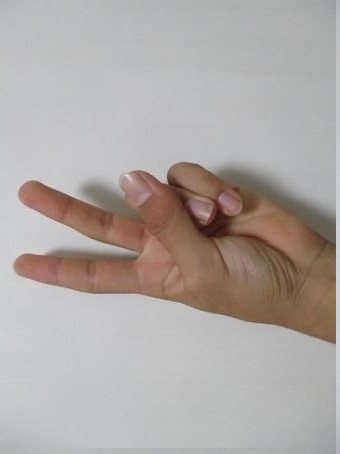

In [369]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = "/home/bititude/Downloads/data_rps_test/sample1.jpeg"
image_path = "/home/bititude/Downloads/data_rps_test/scissors.jpeg"


# image_path ="./dataset/rock/0OEXfEooCXlljaEl.png"

img = Image.open(image_path)
img

In [371]:
def load_image(image_path):

    image = Image.open(image_path)
    image = test_transform(image)
    image = image.unsqueeze(0)

    return image

image = load_image(image_path)

model.eval()
with torch.no_grad():
  output = model(image)
  _,predicted = torch.max(output,1)
  print(f"predicted: {class_names[predicted.item()]}")

predicted: paper
